In [8]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-02-28 13:06:09,859: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator
service = QiskitRuntimeService(channel='ibm_quantum')
service.backends()

[<IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_oslo')>]

## Importing necessarry libraries

Let's start by importing the libraries we need to perform Vartiational Quantum Eigensolver for the Berylium Hydride $BeH_2$ molecule.

In [10]:
# Import necessary libraries and packages
import math
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options


from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Import Qiskit libraries for VQE
from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA

# Import Qiskit Nature libraries
from qiskit_nature.drivers import Molecule
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper

from qiskit_nature.second_q.algorithms import VQEUCCFactory ,NumPyMinimumEigensolverFactory, GroundStateEigensolver
from qiskit_nature.circuit.library import UCC, UCCSD,  HartreeFock

# Prototype-zne
#!pip install prototype-zne --quiet

from qiskit_nature.settings import settings

settings.dict_aux_operators = True

## Helper functions

Here we first use two function helpers functions $\textit{construct_problem}$ and $\textit{construct_problem_BK}$  to build our molecular model. Both will take some molecular properties and return the necessarry ansatz, the fermionic Hamiltonian and the electronic structure proble. 

With the molecular geometry, the charge, the multiplicity, the number of electrons and molecular orbitals defined, this function will define an Electronic structure driver according to these parameters in a given basis.  

The next step is to select our active space which will describe what molecular orbitals will be simulated with VQE. As the problem size increases, the computational cost (number of qubits (which corresponds to the number of orbitals is used) and the circuit depth (which corresponds to the number of electronic excitations considered)) increases rapidly. The active space approach is a well known approach to reduce the computational cost. In many chemistry problems, the orbitals occupied with electrons high in energy and the unoccupied orbitals with low energy play an important role. So, rather than treating all orbitals and electrons with the same accuracy, treating those important electrons and orbitals with high accuracy is a good approximation in general. Therefore, we can select the important orbitals and electrons as our active space and solve the problem with low cost while maintaining the accuracy of the calculation.I used $\textit{ActiveSpaceTransformer}$ to specify how many electrons and molecular orbitals we would like to have in our active space, as well as which of those particular orbitals we would like to consider. After that, we then create an ElectronicStructureProblem that produces a list of fermionic operators that describe the fermionic Hamiltonian in the second quantization.

Because electrons are fermions, the electronic systems are described by Hamiltonians consisting of fermionic operators expressed in second quantization. Since quantum computers are made up of qubits, we have to transform such fermionic Hamiltonians into the qubit operators. For that we use different fermionic to qubit operators mapper from Qiskit Runtime. We focused on comparing two different mappers. The $text_it{Brayvi-Kitae}$ method because is attractive since it focuses on minimizing the Pauli weight of the qubit Hamiltonian ($\textit{construct_problem_BK}$). The Pauli weight is generally referred to the maximum number of qubits on which each Pauli string produced act, i.e. the maximum number of non-identity operators in any Pauli string produced by the mapping. Many features throughout the VQE pipeline are affected by this number. Firstly, low-weight encodings result in lower depth ansätze and lower circuit construction costs. Secondly, it has been shown that using low-weight operators as observable in the VQE cost function provides some resilience against the barren plateau problem. Finally, the lower the Pauli weight, the lower is the overall probability of readout error. This is obvious, as identity operators do not need to be measured, and as such the probability of measurement error increases with the Pauli weight. Despite that, we still wanted to compare it with the slighly worse mapper using $text_it{Parity Mapper}$ ($\textit{construct_problem}$). The interesting part about the later is that we can use the $text_it {two qubit reduction}$ method from Qiskit Runtime to further reduce the number of required qubits and therefore computational cost of the VQE operation. The two qubit reduction converter eliminates the central and last qubit in a list of Paulis that have diagonal operators (Z, I) in those positions. This is a nice method that can be used in chemistry problems to reduce computational resources.


Beyond this, we also generated a parametrised circuit (ansatz) based on the Hartree-Fock ground state as a trial state for our VQE routine.

In [11]:
def construct_problem(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals):
    
    '''
    Function to contruct the problem to be used in a vqe routine for
    
    Args:
        geometry coordinates, charge, multiplicity for the Molecule object,
        basis for ElectronicStructureMoleculeDriver and
        num_molecular_orbitals for the ActiveSpaceTransformer call.
    Returns:
        ansatz circuit, qubit_op_parity Hamiltonian, 
        real_solution converged using the StatevectorSimulator
        problem_reduced which has the reduced ElectronicStructureProblem
    '''

    molecule = Molecule(geometry=geometry,charge=charge, multiplicity=multiplicity) 
    
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Set the active space
    active_space_trafo = ActiveSpaceTransformer(num_electrons=num_electrons,
                                    num_molecular_orbitals=num_molecular_orbitals) 

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    # Set the mapper to qubits
    mapper = ParityMapper() # This is the example of parity mapping

    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    converter = QubitConverter(mapper, two_qubit_reduction=True) 

    # Compute the Hamitonian in qubit form
    qubit_op = converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)
   
    # Get reference solution
    #vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(),ansatz=UCC(excitations='sd')) 
    #solver = GroundStateEigensolver(parity_converter, vqe_factory)    
    #real_solution = solver.solve(problem_reduced).total_energies[0]   
    
    init_state = HartreeFock(num_spin_orbitals=problem_reduced.num_spin_orbitals,
                         num_particles=problem_reduced.num_particles, 
                         qubit_converter=converter)
    ansatz = UCC(
        qubit_converter=converter,
        num_particles=problem_reduced.num_particles, 
        num_spin_orbitals=problem_reduced.num_spin_orbitals,
        excitations='sd',
        initial_state = init_state)
    
    return ansatz, qubit_op, problem_reduced

In [12]:
def construct_problem_BK(geometry, charge, multiplicity, basis, num_electrons, num_molecular_orbitals):
    
    '''
    Function to contruct the problem to be used in a vqe routine for
    
    Args:
        geometry coordinates, charge,multiplicity for the Molecule object,
        basis for ElectronicStructureMoleculeDriver and
        num_molecular_orbitals for the ActiveSpaceTransformer call.
    Returns:
        ansatz circuit, qubit_op_parity Hamiltonian, 
        real_solution converged using the StatevectorSimulator
        problem_reduced which has the reduced ElectronicStructureProblem
    '''

    molecule = Molecule(geometry=geometry,charge=charge, multiplicity=multiplicity) 
    
    driver = ElectronicStructureMoleculeDriver(molecule, basis=basis, driver_type=ElectronicStructureDriverType.PYSCF) 

    # Run the preliminary quantum chemistry calculation
    properties = driver.run()

    # Set the active space
    
    active_space_trafo = ActiveSpaceTransformer(num_electrons=num_electrons,
                                        num_molecular_orbitals=num_molecular_orbitals) 

    # Now you can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()

    # Set the mapper to qubits
    mapper = BravyiKitaevMapper()
    
    # Set the qubit converter with two qubit reduction to reduce the computational cost 
    converter = QubitConverter(mapper, two_qubit_reduction=True) 

    # Compute the Hamitonian in qubit form
    qubit_op = converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)
   
    # Get reference solution
    #vqe_factory = VQEUCCFactory(quantum_instance=StatevectorSimulator(),optimizer=SLSQP(),ansatz=UCC(excitations='sd')) 
    #solver = GroundStateEigensolver(parity_converter, vqe_factory)    
    #real_solution = solver.solve(problem_reduced).total_energies[0]   
    
    init_state = HartreeFock(num_spin_orbitals=problem_reduced.num_spin_orbitals,
                         num_particles=problem_reduced.num_particles, 
                         qubit_converter=converter)
    ansatz = UCC(
        qubit_converter=converter,
        num_particles=problem_reduced.num_particles, 
        num_spin_orbitals=problem_reduced.num_spin_orbitals,
        excitations='sd',
        initial_state = init_state)
    
    return ansatz, qubit_op, problem_reduced

Next, we will define how we shall set our VQE routine with the Estimator Primitive of Qiskit Runtime. Remember, the Estimator will return the estimated expectation values of quantum circuits and observables passed to it. The circuit to pass here will be our ansatz, the observables will be the qubit_op fermionic hamiltonian we will generate from the first helper functions and the parameter_values will be the values processed by the classical optimizer passed here as x. For our example here, we shall be using the Simultaneous perturbation stochastic approximation (SPSA) optimizer for our routine. For the purpose of visualizing the result and getting a view on the internal states of the optimization run, we shall also define a callback function which shall append the convergence value per run and store it in a list to be visualized later.

In [13]:
def custom_vqe(estimator, ansatz, ops, problem_reduced, optimizer = None, initial_point=None):
    
    '''
    custom vqe routine for molecular ground level energy estimation
    
    Args:
        An estimator object which can be any estimator derivation as long as it implements the BaseEstimator class
        ansatz circuit to be evaluated,
        ops observables to be estimated,
        problem_reduced which has the reduced ElectronicStructureProblem for interpreting results
        optimizer if required. Default will be set to SPSA
    Returns:
        vqe_interpret list of interpreted converged values by the optimizer
        job_list list of stored jobs
    
    '''
    # for the random parameters to not change every run
    algorithm_globals.random_seed = 1024
    
    
    # Define convergence list
    convergence = []

    # Keep track of jobs (Do-not-modify)
    job_list = []

    # Define evaluate_expectation function
    def evaluate_expectation(x):
        x = list(x)

        # Define estimator run parameters
        job =  estimator.run(ansatz, ops,[x]).result()
        results = job.values[0]
        job_list.append(job)

        # Pass results back to callback function
        return np.real(results)

    # Call back function
    def callback(x,fx,ax,tx,nx):
        # Callback function to get a view on internal states and statistics of the optimizer for visualization
        convergence.append(evaluate_expectation(fx))

    np.random.seed(10)

    # Define initial point. We shall define a random point here based on the number of parameters in our ansatz
    if initial_point is None:
        initial_point = np.random.random(ansatz.num_parameters)

    # Define optimizer and pass callback function
    if optimizer == None:
        optimizer = SPSA(maxiter=50, callback=callback)

    # Define minimize function
    result =  optimizer.minimize(evaluate_expectation ,initial_point)

    vqe_interpret = []
    for i in range(len(convergence)):
        sol = MinimumEigensolverResult()
        sol.eigenvalue = convergence[i]
        sol = problem_reduced.interpret(sol).total_energies[0]
        vqe_interpret.append(sol)

    return vqe_interpret, job_list, result

We also generated a helper function for plotting the convergence results of our VQE algorithms.

In [14]:
import matplotlib.pyplot as plt

def plot_graph(energy, molecule, color="tab:blue"):
    
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(energy, label="Estimator VQE {}".format(molecule),color = color)

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [H]")
    plt.title("VQE energy")
    plt.show()

We choose to work with the most known linear and symmetric configuration of $BeH_2$ (the two $Be-H$ bonds are oriented 180 degrees apart from each other) with an atomic distance $H-Be$ of $1.33$ Angstroms. In this configuration, the ground state energy of the molecule, computed in the $\textit{6-311G}$ basis is $-15.83396$ Hartrees. We define our molecular geometry using cartesian coordinates centered at the Berylium atom (Be). Next step is to set a chemical driver associated with its charge and mutiplicity in a given basis. In molecular chemistry, multiplicity refers to the number of spin states that a molecule can adopt. The multiplicity of energy levels is defined as $2S + 1$, where $S$ is the total spin of the molecule. Considering the spin of electrons is $\frac{1}{2}$ ,the multiplicity is then related to the number of unpaired electrons in the molecule : $ S = N + 1 $ where N is the number of unpaired electrons. In the case of $BeH_2$, there are no unpaired electrons, as both valence electrons of the beryllium atom are involved in bonding. Its multiplicity is therefore $1$. I choose to compute define the molecular structure problem in the \textit{6-311g} basis bacause the ground state reference value was compute in that basis. When it comes to the number of molecular orbitals $BeH_2$ , BeH2 consists of one beryllium atom and two hydrogen atoms. Beryllium has two valence electrons, which occupy the $2s$ atomic orbital. The two hydrogen atoms have one valence electron each, which occupy the $1s$ atomic orbital. When the Be and H atoms come together to form BeH2, their atomic orbitals overlap to create four molecular orbitals.

## Using Parity Mapper with two qubit reduction

In [28]:
a = 1.333 # Interatomic distance in Angstroms
geo = [["Be", [0.0, 0.0, 0.0]],
            ["H", [a, 0.0, 0.0]],
            ["H",[-a, 0.0, 0.0]]]

ansatz, ops, problem_reduced = construct_problem(geometry=geo, charge=0, multiplicity=1, basis="6-311g", num_electrons=6, num_molecular_orbitals=4)
print(ops) # Fermionic Hamiltonian

-12.212213147892554 * IIIIII
+ 3.2007004370147647 * IIIIIZ
- 0.04514030135319296 * IIIIZX
+ 0.04514030135319296 * IIIIIX
+ 0.6016111600259298 * IIIIZZ
+ 0.5852837104263732 * IIIZZI
- 0.30485816322879267 * IIIZII
- 3.2007004370147647 * IIZIII
+ 0.04514030135319291 * IZXIII
+ 0.04514030135319291 * IIXIII
+ 0.6016111600259302 * IZZIII
+ 0.5852837104263734 * ZZIIII
+ 0.30485816322879267 * ZIIIII
+ 0.04969077462510032 * IIIIZI
+ 0.05214855316140924 * IIIZZZ
- 0.017324362865332087 * IIIZIZ
- 0.0047893982564159035 * IIIZIX
+ 0.0047893982564159035 * IIIZZX
- 0.5671060328243879 * IIZIIZ
+ 0.04185361505178516 * IIZIZX
- 0.04185361505178516 * IIZIIX
+ 0.04185361505178516 * IZXIIZ
+ 0.04185361505178516 * IIXIIZ
- 0.004803497807859238 * IZXIZX
- 0.004803497807859238 * IIXIZX
+ 0.004803497807859238 * IZXIIX
+ 0.004803497807859238 * IIXIIX
- 0.0015111851013140444 * ZXXZXX
+ 0.0015111851013140444 * IYYZXX
- 0.0015111851013140444 * ZXXIYY
+ 0.0015111851013140444 * IYYIYY
+ 0.0007107852873749015 * XXXXX

One very attractive aspect of Qiskit Runtime is the availibility of specific Quantum Error Correction and Mitigation tools from the Estimator primitive. 
Here we use $\textit{options.optimization_level = 3}$ corresponding to the use of an error mitigation technique called Dynamic Decoupling. Dynamic decoupling (DD) is used to increase the lifetime of quantum information. If a qubit is idle, it becomes noisy because of decoherence, leaking information to surroundings. To prevent this idle state, we effectively disconnect the environment using so-called decoupling methods; scan the circuit for idle periods of time (i.e. those containing delay instructions) and insert a DD sequence of gates in those spots. These gates amount to the identity, so do not alter the logical action of the circuit, but have the effect of mitigating decoherence in those idle periods. However, this technique may not better the situation if you do not use a proper DD sequence because the pulses have finite lengths and do not implement perfect rotations. As a result, it is important to have an optimal decoupling sequence which does not destroy the qubit coherence instead of preserving it.
By activating $\textit{options.resilience_level = 2}$ , we choose to apply an error mitigation tehcnique called Digital Zero Noise Extrapolation (ZNE). Digital Zero Noise Extrapolation (ZNE) is a popular technique for mitigating errors in noisy quantum computers without the need for additional quantum resources. A quantum program is altered to run at different effect levels of processor noise. The result of the computation is extrapolated to an estimated value at a noiseless level.  To find the proper value, Digital ZNE firstly scales noise as explained above. There are two kinds of methods for scaling it: analog and digital. It is still an active research question around which method is the best to use. Note that the digital way is by not acting on the physical quantum pulses.

In [ ]:
# define backend for Estimator
backend = service.backend("ibmq_qasm_simulator")
#backend = service.backend("ibm_nairobi")
#backend = service.backend("ibmq_jakarta")

# define options for Estimator
options = Options()

#options.execution.shots = 5
options.optimization_level = 3 # Dynamic Decoupling for error correction
options.resilience_level = 2  # Zero noise Extraplotaion for error mitigation
    
# inititilize the estimator 
estimator = Estimator(session=backend, options=options)

Energy, _ , jobs = custom_vqe(estimator, ansatz, ops, problem_reduced)

In [21]:
print("Computed Energy:", Energy[-1])

Computed Energy: (-15.394879592588708+0j)


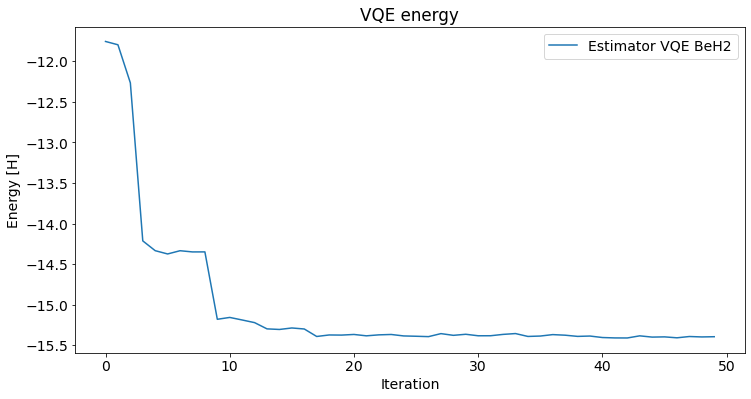

In [22]:
plot_graph(Energy, "BeH2")

## Using Brayvi-Kitae Mapper

In [16]:
ansatz_BK, ops_BK, problem_reduced_BK = construct_problem_BK(geometry=geo, charge=0, multiplicity=1, basis="6-311g", num_electrons=6, num_molecular_orbitals=4)
print(ops_BK) # Fermionic Hamiltonian

-12.212213147892559 * IIIIIIII
+ 3.200700437014766 * IIIIIIIZ
- 0.0451403013531926 * IIIIIIZX
+ 0.0451403013531926 * IIIIIIIX
+ 0.60161116002593 * IIIIIIZZ
+ 0.5852837104263745 * IIIIIZII
+ 0.30485816322879167 * IIIIZZZI
+ 3.2007004370147656 * IIIZIIII
- 0.04514030135319255 * IIZXIIII
+ 0.04514030135319255 * IIIXIIII
+ 0.60161116002593 * IIZZIIII
+ 0.5852837104263748 * IZIIIIII
+ 0.3048581632287919 * ZZZIZIII
+ 0.10992594320084235 * IIIIIIZI
+ 0.1095127270063623 * IIIIIZIZ
+ 0.07645656758024001 * IIIIZZZZ
- 0.0035908863474944483 * IIIIIZZX
+ 0.0035908863474944483 * IIIIIZIX
- 0.0011985119089214613 * IIIIZZIX
+ 0.0011985119089214613 * IIIIZZZX
+ 0.5671060328243893 * IIIZIIIZ
- 0.04185361505178521 * IIIZIIZX
+ 0.04185361505178521 * IIIZIIIX
- 0.04185361505178521 * IIZXIIIZ
+ 0.04185361505178521 * IIIXIIIZ
+ 0.004803497807859245 * IIZXIIZX
- 0.004803497807859245 * IIIXIIZX
- 0.004803497807859245 * IIZXIIIX
+ 0.004803497807859245 * IIIXIIIX
+ 0.0015111851013140483 * IYYXIYYX
- 0.0015111851

In [18]:
# define backend
backend = service.backend("ibmq_qasm_simulator")
#backend = service.backend("ibm_nairobi")
#backend = service.backend("ibmq_jakarta")

# define options for Estimator
options = Options()

#options.execution.shots = 5
options.optimization_level = 3 # Dynamic Decoupling for error correction
options.resilience_level = 2  # Zero noise Extraplotaion for error mitigation
    
# inititilize the estimator 
estimator = Estimator(session=backend, options=options)
Energy_BK, _ , jobs_BK = custom_vqe(estimator, ansatz_BK, ops_BK, problem_reduced_BK)

In [20]:
print("Computed Energy with BK:", Energy_BK[-1])

Computed Energy with BK: (-15.39497039328359+0j)


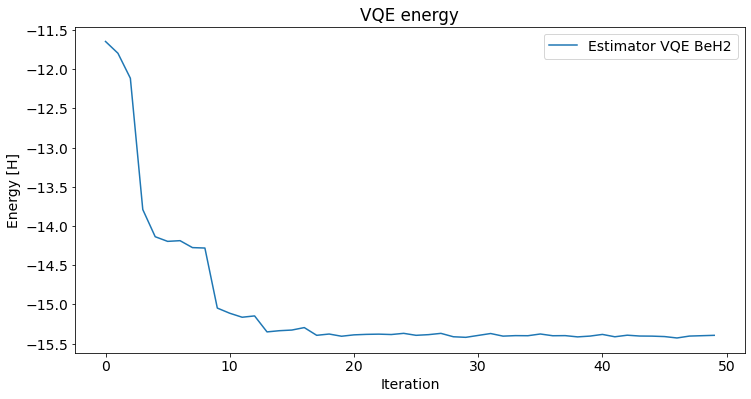

In [21]:
plot_graph(Energy_BK, "BeH2")